In [2]:
print("Hello world")

Hello world


## 0. 必要な関数の定義

In [3]:
import os
import shutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from IPython.display import Audio
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm


def plot_features(features):
    """特徴量散布図（2次元）をプロット"""
    if features.shape[1] == 2:
        reduced_features = features
    else:
        tsne = TSNE(n_components=2, random_state=42)
        reduced_features = tsne.fit_transform(features)

    # 2Dプロット作成
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
    plt.title("2D Plot of Embeddings")
    plt.show()


def plot_clusters(features, cluster_assignments):
    """クラスターごとに色分けした2次元特徴量散布図をプロット"""
    n_clusters = np.max(cluster_assignments) + 1
    min_cluster_id = np.min(cluster_assignments)

    if features.shape[1] == 2:
        reduced_features = features
    else:
        tsne = TSNE(n_components=2, random_state=42)
        reduced_features = tsne.fit_transform(features)

    fig, ax = plt.subplots(figsize=(6, 5))

    # カラーマップを取得
    cmap = matplotlib.colormaps["tab20"]

    # クラスターごとに色分けしたプロットを作成
    for cluster_id in range(min_cluster_id, n_clusters):
        cluster_points = reduced_features[cluster_assignments == cluster_id]
        if cluster_id == -1:
            label = "Noise"
            color = "black"
        else:
            label = f"Cluster {cluster_id}"
            color = cmap((cluster_id - min_cluster_id) / (n_clusters - min_cluster_id))
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=label, color=color)

    # タイトルと凡例を設定
    if features.shape[1] == 2:
        plt.title("2D Plot of Clustering")
    else:
        plt.title("2D Plot of Clustering via tSNE")

    # 凡例を図の右側に表示
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # プロットを表示
    plt.show()


def perform_dbscan(features, eps, min_samples):
    """DBSCANを用いてクラスタリングを実行"""
    # クラスタリングの実行
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_assignments = dbscan.fit_predict(features)

    n_clusters = np.max(cluster_assignments) + 1

    print("Number of clusters:", n_clusters)

    # ノイズ分類されたデータ数を計算
    n_noise = np.sum(cluster_assignments == -1)

    # ノイズ分類された割合を計算
    noise_ratio = n_noise / len(cluster_assignments) * 100

    # 結果を表示
    print(f"Noise / Total files: {n_noise} / {len(cluster_assignments)}")
    print(f"Noise ratio: {noise_ratio:.2f}%")

    return cluster_assignments


def sorted_indices(features, cluster_assignments):
    """
    クラスタごとに距離の総和が小さい順に添字をソートして、
    クラスタごとに添字をリストに格納して返す
    """
    # クラスタごとに処理
    sorted_indices_by_cluster = []
    n_clusters = np.max(cluster_assignments) + 1

    for i in range(n_clusters + 1):
        if i == n_clusters:  # ノイズクラスターは最後に付け加えて、[-1]で取得できるように
            label = -1
        else:
            label = i
        # クラスタ内の添字を取得
        indices = np.where(cluster_assignments == label)[0]

        # 同じクラスタ内の点との距離の総和を計算
        distances = cdist(features[indices], features[indices]).sum(axis=1)

        # 距離の総和が小さい順に添字をソート
        sorted_indices = indices[np.argsort(distances)]

        # ソート済み添字をリストに追加
        sorted_indices_by_cluster.append(sorted_indices)

    return sorted_indices_by_cluster


def get_duration(file):
    info = sf.info(file)
    return info.duration


def get_audio_durations(wav_files):
    durations = []
    for file in wav_files:
        info = sf.info(file)
        duration = info.duration
        durations.append(duration)
    return durations


def cluster_durations(cluster_assignments, wav_files):
    durations = get_audio_durations(wav_files)
    n_clusters = np.max(cluster_assignments) + 1

    cluster_total_durations = []
    for i in range(n_clusters):
        indices = np.where(cluster_assignments == i)
        cluster_duration = np.sum(np.array(durations)[indices])
        cluster_total_durations.append(cluster_duration)

    return cluster_total_durations


def cluster_stds(features, cluster_assignments, metric="euclidean"):
    """
    各クラスターのデータの距離の標準偏差を計算
    """
    n_clusters = np.max(cluster_assignments) + 1
    std_distances = []

    for i in range(n_clusters):
        cluster_points = features[cluster_assignments == i]
        distances = pairwise_distances(cluster_points, metric=metric)
        std_distances.append(np.std(distances))

    return std_distances


def display_cluster_stats(features, cluster_assignments, wav_files):
    """
    各クラスターのデータ数、標準偏差、総時間のグラフを表示
    """
    std_distances = cluster_stds(features, cluster_assignments)

    total_durations = cluster_durations(cluster_assignments, wav_files)
    total_durations_minutes = [
        duration / 60 for duration in total_durations
    ]  # Convert to minutes

    n_clusters = np.max(cluster_assignments) + 1

    cluster_sizes = [np.sum(cluster_assignments == i) for i in range(n_clusters)]

    fig, ax1 = plt.subplots()

    ax1.bar(range(n_clusters), cluster_sizes, color="b", alpha=0.5, label="Data count")
    ax1.set_xlabel("Cluster")
    ax1.set_ylabel("Data count")
    ax1.tick_params("y", colors="b")

    ax2 = ax1.twinx()
    ax2.plot(
        range(n_clusters),
        std_distances,
        color="r",
        marker="o",
        label="Standard deviation",
    )
    ax2.set_ylabel("Standard deviation")
    ax2.tick_params("y", colors="r")

    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    ax3.bar(
        range(n_clusters),
        total_durations_minutes,
        color="g",
        alpha=0.5,
        label="Total duration",
    )
    ax3.set_ylabel("Total duration (min)")
    ax3.tick_params("y", colors="g")

    fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))

    plt.title("Data count, standard deviation, and total duration per cluster")
    plt.show()


def play_cluster_reps(wav_files, features, cluster_assignments, n_samples=3, id=None):
    """
    与えられたクラスターの代表的な音声と、代表から最も離れた音声をそれぞれ`n_samples`個を再生
    """
    if id is None:
        id = int(input("クラスター分類番号: "))

    sorted_indices_by_cluster = sorted_indices(features, cluster_assignments)
    cluster_files = [
        wav_files[index] for index in sorted_indices_by_cluster[id][:n_samples]
    ]
    anti_cluster_files = [
        wav_files[index] for index in sorted_indices_by_cluster[id][-n_samples:]
    ]
    print(f"クラスタ {id}: データ数 {np.sum(cluster_assignments == id)}")
    for j, file in enumerate(cluster_files):
        print(f"  代表 {j + 1}: {file}")
        display(Audio(file))
    for j, file in enumerate(anti_cluster_files):
        print(f"  anti代表 {j + 1}: {file}")
        display(Audio(file))


def copy_wav_files_to_clusters(
    wav_files,
    features,
    cluster_assignments,
    total_duration_limit=60 * 60,
    cluster_index=None,
    output_dir="clusters",
):
    """
    `output_dir`に各クラスター内の音声を、代表的なものから1.wav, 2.wav, ...と名前をつけて、合計`total_duration_limit`秒以内になるまでコピー。
    `cluster_index`が`None`の場合、すべてのクラスターの音声を`output_dir/{cluster_id}/`にコピー。
    `cluster_index`が`None`でない場合、`cluster_index`のクラスターの音声を`output_dir`にコピー。
    """
    os.makedirs(output_dir, exist_ok=True)

    min_cluster_id = np.min(cluster_assignments)
    n_clusters = np.max(cluster_assignments) + 1
    sorted_indices_by_cluster = sorted_indices(features, cluster_assignments)

    for i in range(min_cluster_id, n_clusters):
        if i == -1:  # Skip noise cluster
            continue
        if cluster_index is not None and cluster_index != i:
            continue
        print(f"Copying cluster number {i}")

        if cluster_index is None:
            cluster_dir = os.path.join(output_dir, f"cluster_{i}")
        else:
            cluster_dir = output_dir
        if not os.path.exists(cluster_dir):
            os.makedirs(cluster_dir)

        indices = sorted_indices_by_cluster[i]
        total_duration = 0
        file_counter = 1

        for index in tqdm(indices):
            file = wav_files[index]

            file_duration = get_duration(file)  # Use the renamed function
            if total_duration + file_duration > total_duration_limit:
                break
            new_file_name = f"{file_counter}.wav"
            shutil.copy(file, os.path.join(cluster_dir, new_file_name))
            total_duration += file_duration
            file_counter += 1

    print(f"Copied wav files to {output_dir} directory.")

## 1. データ集め

wav ファイルを集めてパスを`wav_files`リストに格納する。
`wav_path`にwavファイルがあるディレクトリを指定してください。

In [4]:
# ここにwavファイルが入っているディレクトリを指定
wav_path = "path/to/wav/files/"

wav_files = [
    os.path.join(wav_path, f) for f in os.listdir(wav_path) if f.endswith(".wav")
]
print(f"There are {len(wav_files)} wav files.")

There are 754 wav files.


In [5]:
# 必要ならば、合計時間を計算

print(f"Total: {sum(get_audio_durations(wav_files)) / 60:.2f} minutes")

Total: 105.98 minutes


## 2. Pyannoteの話者埋め込みを計算

[pyannote/embedding](https://huggingface.co/pyannote/embedding) を使って、各wavファイルの512次元特徴量を計算します。
事前に [pyannote/embedding](https://huggingface.co/pyannote/embedding) で同意をし、hugging faceのトークンを [`hf.co/settings/tokens`](https://hf.co/settings/tokens) から発行してください。


In [ ]:
import torch
from pyannote.audio import Model, Inference

token = "hf_yourAccessTokenHere"
model = Model.from_pretrained("pyannote/embedding", use_auth_token=token)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference = Inference(model, window="whole", device=device)

In [7]:
# Pyannoteの埋め込み辞書を作成して、{wav_path}/pa_dict.pklに保存

pa_dict = {}
for file in tqdm(wav_files, desc="Generating Pyannote embeddings"):
    pa_dict[file] = inference(file)

import pickle

# 保存
with open(os.path.join(wav_path, "pa_dict.pkl"), "wb") as f:
    pickle.dump(pa_dict, f)

Generating Pyannote embeddings:   0%|          | 0/754 [00:00<?, ?it/s]

In [7]:
# 上で保存していた場合は読み込み
import pickle

with open(os.path.join(wav_path, "pa_dict.pkl"), "rb") as f:
    pa_dict = pickle.load(f)

wavファイルからさらにピッチや有声区間率等で事前フィルタリングしたい場合は、各自フィルタしてそれを`wav_files`に追加しなおしてください。

すべてのwavファイルに対する特徴量を上ですでに計算しているので、ここの処理は速いはずです。

In [8]:
# 埋め込み配列を作成して、{wav_path}/pa_embeddings.npyに保存

pa_embeddings = [pa_dict[file] for file in wav_files]
pa_embeddings = np.array(pa_embeddings)
print("Embeddings created.")
np.save(os.path.join(wav_path, "pa_embeddings.npy"), pa_embeddings)

Embeddings created.


In [9]:
pa_embeddings.shape

(754, 512)

## 3. 次元を2次元に削減して、クラスター分け

上で得られた特徴量は512次元ですが、体感ではそのまま使うより、あえて2次元にt-SNEに次元を削減してから図を見ながらクラスター分けする方が良い結果が得られることが多いので、そうしています。

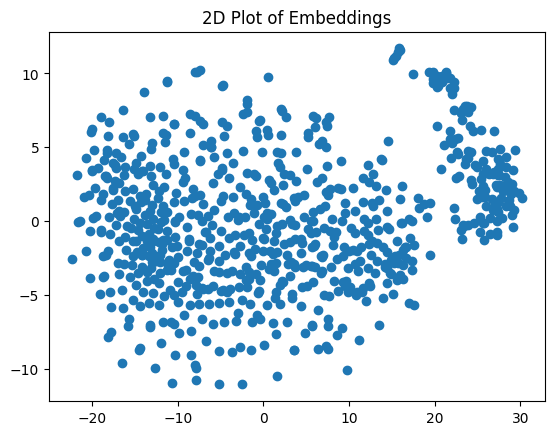

In [10]:
# 2次元に削減してプロット

tsne = TSNE(n_components=2, random_state=42, metric="cosine")
reduced_pa_embeddings_2d = tsne.fit_transform(pa_embeddings)
np.save(
    os.path.join(wav_path, "reduced_pa_embeddings_2d.npy"), reduced_pa_embeddings_2d
)
plot_features(reduced_pa_embeddings_2d)

次にこの図を見ながら [DBSCAN](https://ja.wikipedia.org/wiki/DBSCAN) でクラスタリングを行います。`eps`と`min_samples`はWikipedia等を見ながら適宜調整してください。

Number of clusters: 2
Noise / Total files: 76 / 754
Noise ratio: 10.08%


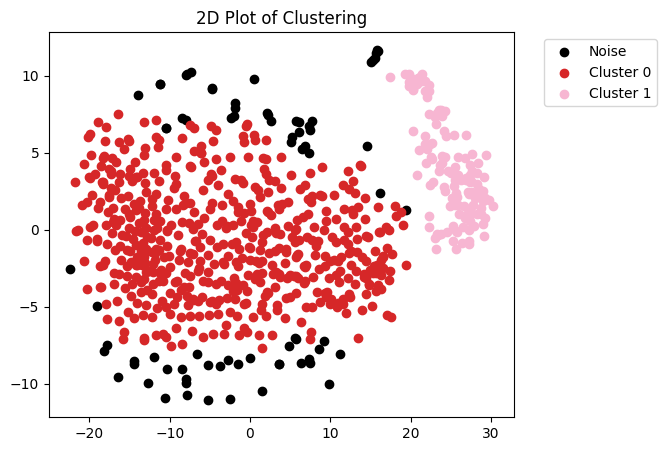

In [11]:
# `eps`と`min_samples`を与えて、DBSCANを行い結果をプロット
eps = 2.3
min_samples = 14

features = reduced_pa_embeddings_2d
cluster_assignments = perform_dbscan(features, eps=eps, min_samples=min_samples)

plot_clusters(features, cluster_assignments)

In [ ]:
# クラスター番号を指定して、そのクラスターの代表的な音声・anti代表的な音声を再生

id = 0  # クラスター番号を指定
n_samples = 5  # 何個再生するか
play_cluster_reps(wav_files, features, cluster_assignments, n_samples, id)

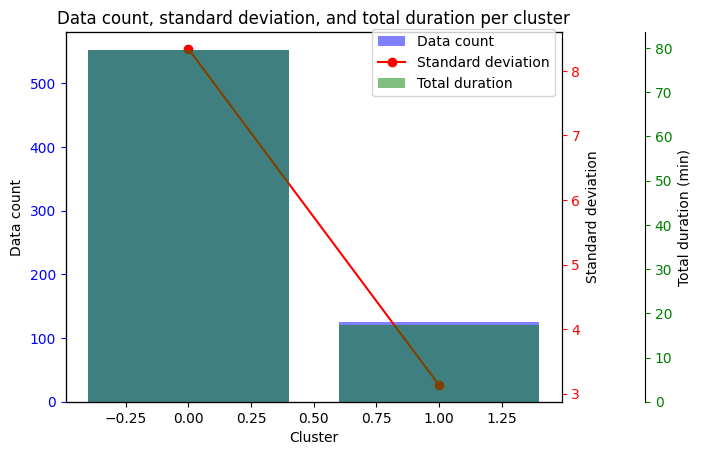

In [13]:
# クラスターごとのデータ数、標準偏差、総時間を表示

display_cluster_stats(features, cluster_assignments, wav_files)

# 4. クラスタリングの結果から wav ファイルを保存

クラスター分けされた結果を用いて、各クラスターに対して一番代表的な元から`1.wav`, `2.wav`, ...というファイル名で、設定された合計上限時間を超えないようにwavファイルを保存します。

In [14]:
output_dir = "path/to/output/dir"

total_dur_minutes = 60  # クラスターごとにコピーする音声の上限合計時間（分）
cluster_index = 0  # 0番目のクラスターの音声のみをコピーする場合
# cluster_index = None  # すべてのクラスターの音声をコピーする場合

copy_wav_files_to_clusters(
    wav_files,
    features,
    cluster_assignments,
    total_duration_limit=60 * total_dur_minutes,
    output_dir=output_dir,
    cluster_index=cluster_index,
)

Copying cluster number 0


  0%|          | 0/553 [00:00<?, ?it/s]

Copied wav files to path/to/output/dir directory.
